follows ideas from https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building the dataset

In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [22]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X, Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([228146, 3]) torch.Size([228146])
torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


There are 228,146 examples of 3-character subwords. These are encoded as integers from 0 to 26 with the . counting as an additional charcater.

These are split up into training, validation (dev) and test set. The validation set is hereby used to tune hyperparameters and might help for model selection.

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

❗ Be careful about the dimensionality of the weights tensor.

The bias is shifting the prediction line up or down. Essentially, like an intercept but here we have a higher dimensional space. Hence, its like shifting a hyperplane.

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [26]:
for p in parameters:
  p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [28]:
lri = []
lossi = []
stepi = []

### Training the neural net

In [29]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01   # scrappy learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

The minibatch is used to only train on parts of the training set. This makes training much faster and also (I believe) stochastic aka Stochastic gradient descent because the sample that are used are drawn randomly. In practice, you should cycle through the dataset such that every element from the train data is guaranteed to be used.

Cross_entropy() is calculating the negative (average) log likelihood more efficiently as intermediate tensors are not needed.

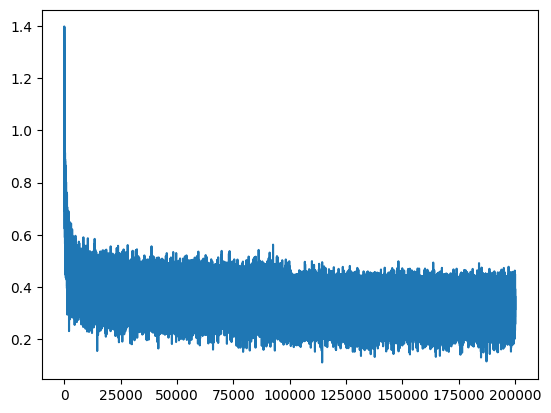

In [30]:
plt.plot(stepi, lossi)

In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1175, grad_fn=<NllLossBackward0>)

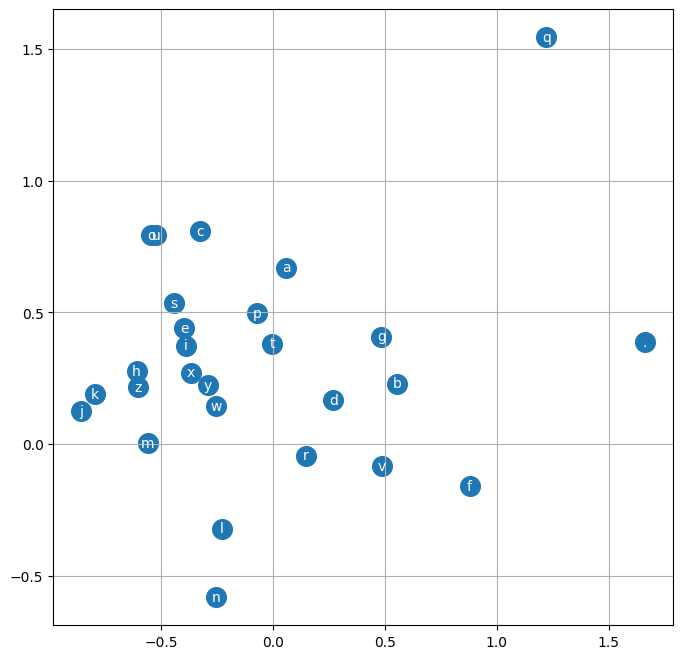

In [32]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Vowels are close to each other, meaning they share some characteristics, e.g. following after certain types of 3 character subwords.

### Sample names from the MLP model

In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nihayla.
rethan.
endraeg.
azelynnelin.
shi.
jenleigh.
van.
narleigh.
malaia.
nosalbergshiriel.
kinleenellennie.
con.
brence.
rhylani.
els.
kaylah.
keyah.


Better than the bigram model :D